# Similarity metrics between captions

## Semantic similarity, structure similarity

### Initialisation of the absolute Github repository path :

In [1]:
from pathlib import Path
import sys

root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)

Root folder at:  c:\Users\cyrie\OneDrive\Documents\EPFL\2025_MA_1\ADA\ada-2025-project-adacore42


### Imports:

In [2]:
# Install Sentence Transformer for the semantic embedding purpose (Sentence-BERT (SBERT) model is used) :
# pip install -U sentence-transformers

In [25]:
# utils
from src.utils.general_utils import *

# paths
from src.utils.paths import *

# working librairies
import os
import pickle


# classic librairies
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# text processing librairies
import nltk
from collections import Counter
import re
from textblob import TextBlob
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# statistical libraries
from statsmodels.stats import diagnostic
from scipy.stats import spearmanr, pearsonr
import networkx as nx


In [4]:
# Download NLTK resources if not already
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

### Loading of preprocessed data's pickle :

In [5]:
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

In [ ]:
# Chargement du fichier pickle
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

# Extraction des objets stockés dans le pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']


In [7]:
dataA[77]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny
rank,,,,,,,
0,Can I tell you about a few items that aren't o...,1.962439,0.015871,2476,820,929,727
1,We're out of that too.,1.960586,0.018005,1979,675,707,597
2,Thank you for actually reading the entire menu...,1.929282,0.018846,1810,650,638,522
3,"If you'd like, I can have the sommelier drag o...",1.913781,0.020508,1415,487,563,365
4,Wait 'til you see the check.,1.913360,0.015410,2747,1025,935,787
...,...,...,...,...,...,...,...
6085,You're the smallest person we've ever had here!,1.000000,0.016261,62,62,0,0
6086,Wait till you see the size of our dessert menu!,1.000000,0.016261,62,62,0,0
6087,Welcome to Texas.,1.000000,0.005168,194,194,0,0


In [8]:
dataC.head()

,num_captions,num_votes,image_locations,image_descriptions,image_uncanny_descriptions,entities,questions,date
0,3905.0,41185.0,[the street],[A man is relaxing on a city street. Others ar...,[A man is just laying in the middle of the sid...,[https://en.wikipedia.org/wiki/Bystander_effec...,[Why is he laying there?],NaT
1,3325.0,28205.0,"[the front hard, a residential walkway]",[A man in a winter coat and cap is looking at ...,[It's unusual to see someone holding a snow sh...,"[https://en.wikipedia.org/wiki/Snowball_fight,...",[Is the man overly small or the shovel overly ...,NaT
2,4399.0,21574.0,"[yoga place, a yoga studio]",[A man and woman are standing facing one anoth...,[Nothing is really out of place in this image....,"[https://en.wikipedia.org/wiki/Rug, https://en...","[Why is the man carrying a huge rug?, Why is t...",2016-03-21
3,4141.0,16894.0,"[a workplace, an elevator]",[Three business men are walking down a hall. T...,[A suit case is usually carried by one person ...,[https://en.wikipedia.org/wiki/Worker_cooperat...,[Why is the briefcase big enough for three peo...,2016-03-27
4,3951.0,95790.0,[plains],[Some cowboys are riding through the desert. T...,[There are rocking horses in place of real hor...,"[https://en.wikipedia.org/wiki/Rocking_horse, ...",[Why is this chase taking place?],2016-04-03


In [9]:
# Calculate semantic similarity :
def compute_semantic_similarity(df, text_col='caption', model_name='all-MiniLM-L6-v2'):

    model = SentenceTransformer(model_name)
    
    embeddings = model.encode(df[text_col].tolist(), convert_to_tensor=True)
    
    semantic_sim = util.cos_sim(embeddings, embeddings)

    return semantic_sim



# Calculate structure similarity :
def extract_structure_features(text):
    text = str(text)
    words = re.findall(r"\b\w+\b", text)
    punct = re.findall(r"[^\w\s]", text)
    letters = re.findall(r"[A-Za-z]", text)
    digits = re.findall(r"\d", text)

    n_chars = len(text)
    n_words = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    punct_density = len(punct) / n_chars if n_chars > 0 else 0
    upper_ratio = sum(1 for c in text if c.isupper()) / len(letters) if letters else 0
    digit_ratio = len(digits) / n_chars if n_chars > 0 else 0

    return [n_chars,
            n_words,
            avg_word_len,
            punct_density,
            upper_ratio,
            digit_ratio]
        
def compute_structure_similarity(df, text_col='caption'):
    """
    Cosinus similarity based on:
    - Longueur du texte
    - Nombre de mots
    - Moyenne de longueur des mots
    - Densité de ponctuation
    - Ratio majuscules/minuscules
    - Ratio de chiffres
    """
    features = np.array([extract_structure_features(t) for t in df[text_col]])
    
    # Normalisation of the features: 
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Calcul de similarité cosinus
    structure_sim = cosine_similarity(features_scaled)
    return structure_sim





def compute_combined_similarity(semantic_sim, structural_sim, semantic_sim_ratio=0.5, structural_sim_ratio=0.5):
    combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim
    return combined_sim_matrix




# Similarity matrix
def plot_similarity_matrix(df, text_col='caption', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0.5, structural_sim_ratio=0.5, sample_size=None):
    """
    Calcule et visualise la matrice de similarité sémantique entre captions.
    
    captions : liste de phrases
    model_name : modèle SBERT à utiliser
    mode : 'seaborn' ou 'plotly'
    sample_size : nombre de captions à afficher (pour éviter une matrice trop grande)
    """

    # Échantillonnage si nécessaire
    if sample_size!=None and len(df) > sample_size:
        df = df.head(sample_size).reset_index(drop=True)
    #    df = df.sample(sample_size, random_state=42).reset_index(drop=True)

    captions = df[text_col].tolist()
    
    semantic_sim = compute_semantic_similarity(df, text_col=text_col, model_name=model_name)
    structural_sim = compute_structure_similarity(df, text_col=text_col)
    sim_matrix = compute_combined_similarity(semantic_sim, structural_sim, semantic_sim_ratio, structural_sim_ratio)

    df_sim = pd.DataFrame(sim_matrix, index=captions, columns=captions)

    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_sim, cmap="coolwarm", xticklabels=True, yticklabels=True)
    plt.title("Matrice de similarité sémantique (SBERT)")
    plt.show()
    
    return df_sim



# Humour similarity
def analyze_humor_similarity(df, text_col='caption', humor_col='funny', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0, structural_sim_ratio=1, sample_size=None):
    """
    Analyse la relation entre similarité sémantique et score d’humour.
    
    - Calcule toutes les paires de captions
    - Compare leur similarité sémantique (SBERT)
    - Compare leur écart de score d’humour
    - Calcule la corrélation entre les deux
    """

    # Échantillonnage si nécessaire
    if sample_size!=None and len(df) > sample_size:
        df = df.head(sample_size).reset_index(drop=True)
    #    df = df.sample(sample_size, random_state=42).reset_index(drop=True)


    semantic_sim = compute_semantic_similarity(df, text_col=text_col, model_name=model_name)
    structural_sim = compute_structure_similarity(df, text_col=text_col)
    sim_matrix = compute_combined_similarity(semantic_sim, structural_sim, semantic_sim_ratio, structural_sim_ratio)
    
    # Extraire les valeurs de similarité et de différence de score d’humour
    sims = []
    humor_diffs = []
    scores = df[humor_col].to_numpy()
    n = len(scores)
    
    for i in range(n):
        for j in range(i+1, n):
            sims.append(sim_matrix[i, j])
            humor_diffs.append(abs(scores[i] - scores[j]))
    
    sims = np.array(sims)
    humor_diffs = np.array(humor_diffs)
    
    # Corrélation entre similarité et écart d’humour
    corr_spearman, _ = spearmanr(sims, -humor_diffs)
    corr_pearson, _ = pearsonr(sims, -humor_diffs)
    
    # Visualisation
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=sims, y=-humor_diffs, alpha=0.5)
    plt.xlabel("Similarité sémantique")
    plt.ylabel("Proximité du score d’humour (inverse de l’écart)")
    plt.title(f"Corrélation humour/similarité\nSpearman = {corr_spearman:.2f}, Pearson = {corr_pearson:.2f}")
    plt.show()
    
    return {
        'spearman': corr_spearman,
        'pearson': corr_spearman
    }



C:\Users\cyrie\AppData\Local\Temp\ipykernel_33264\3945235727.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


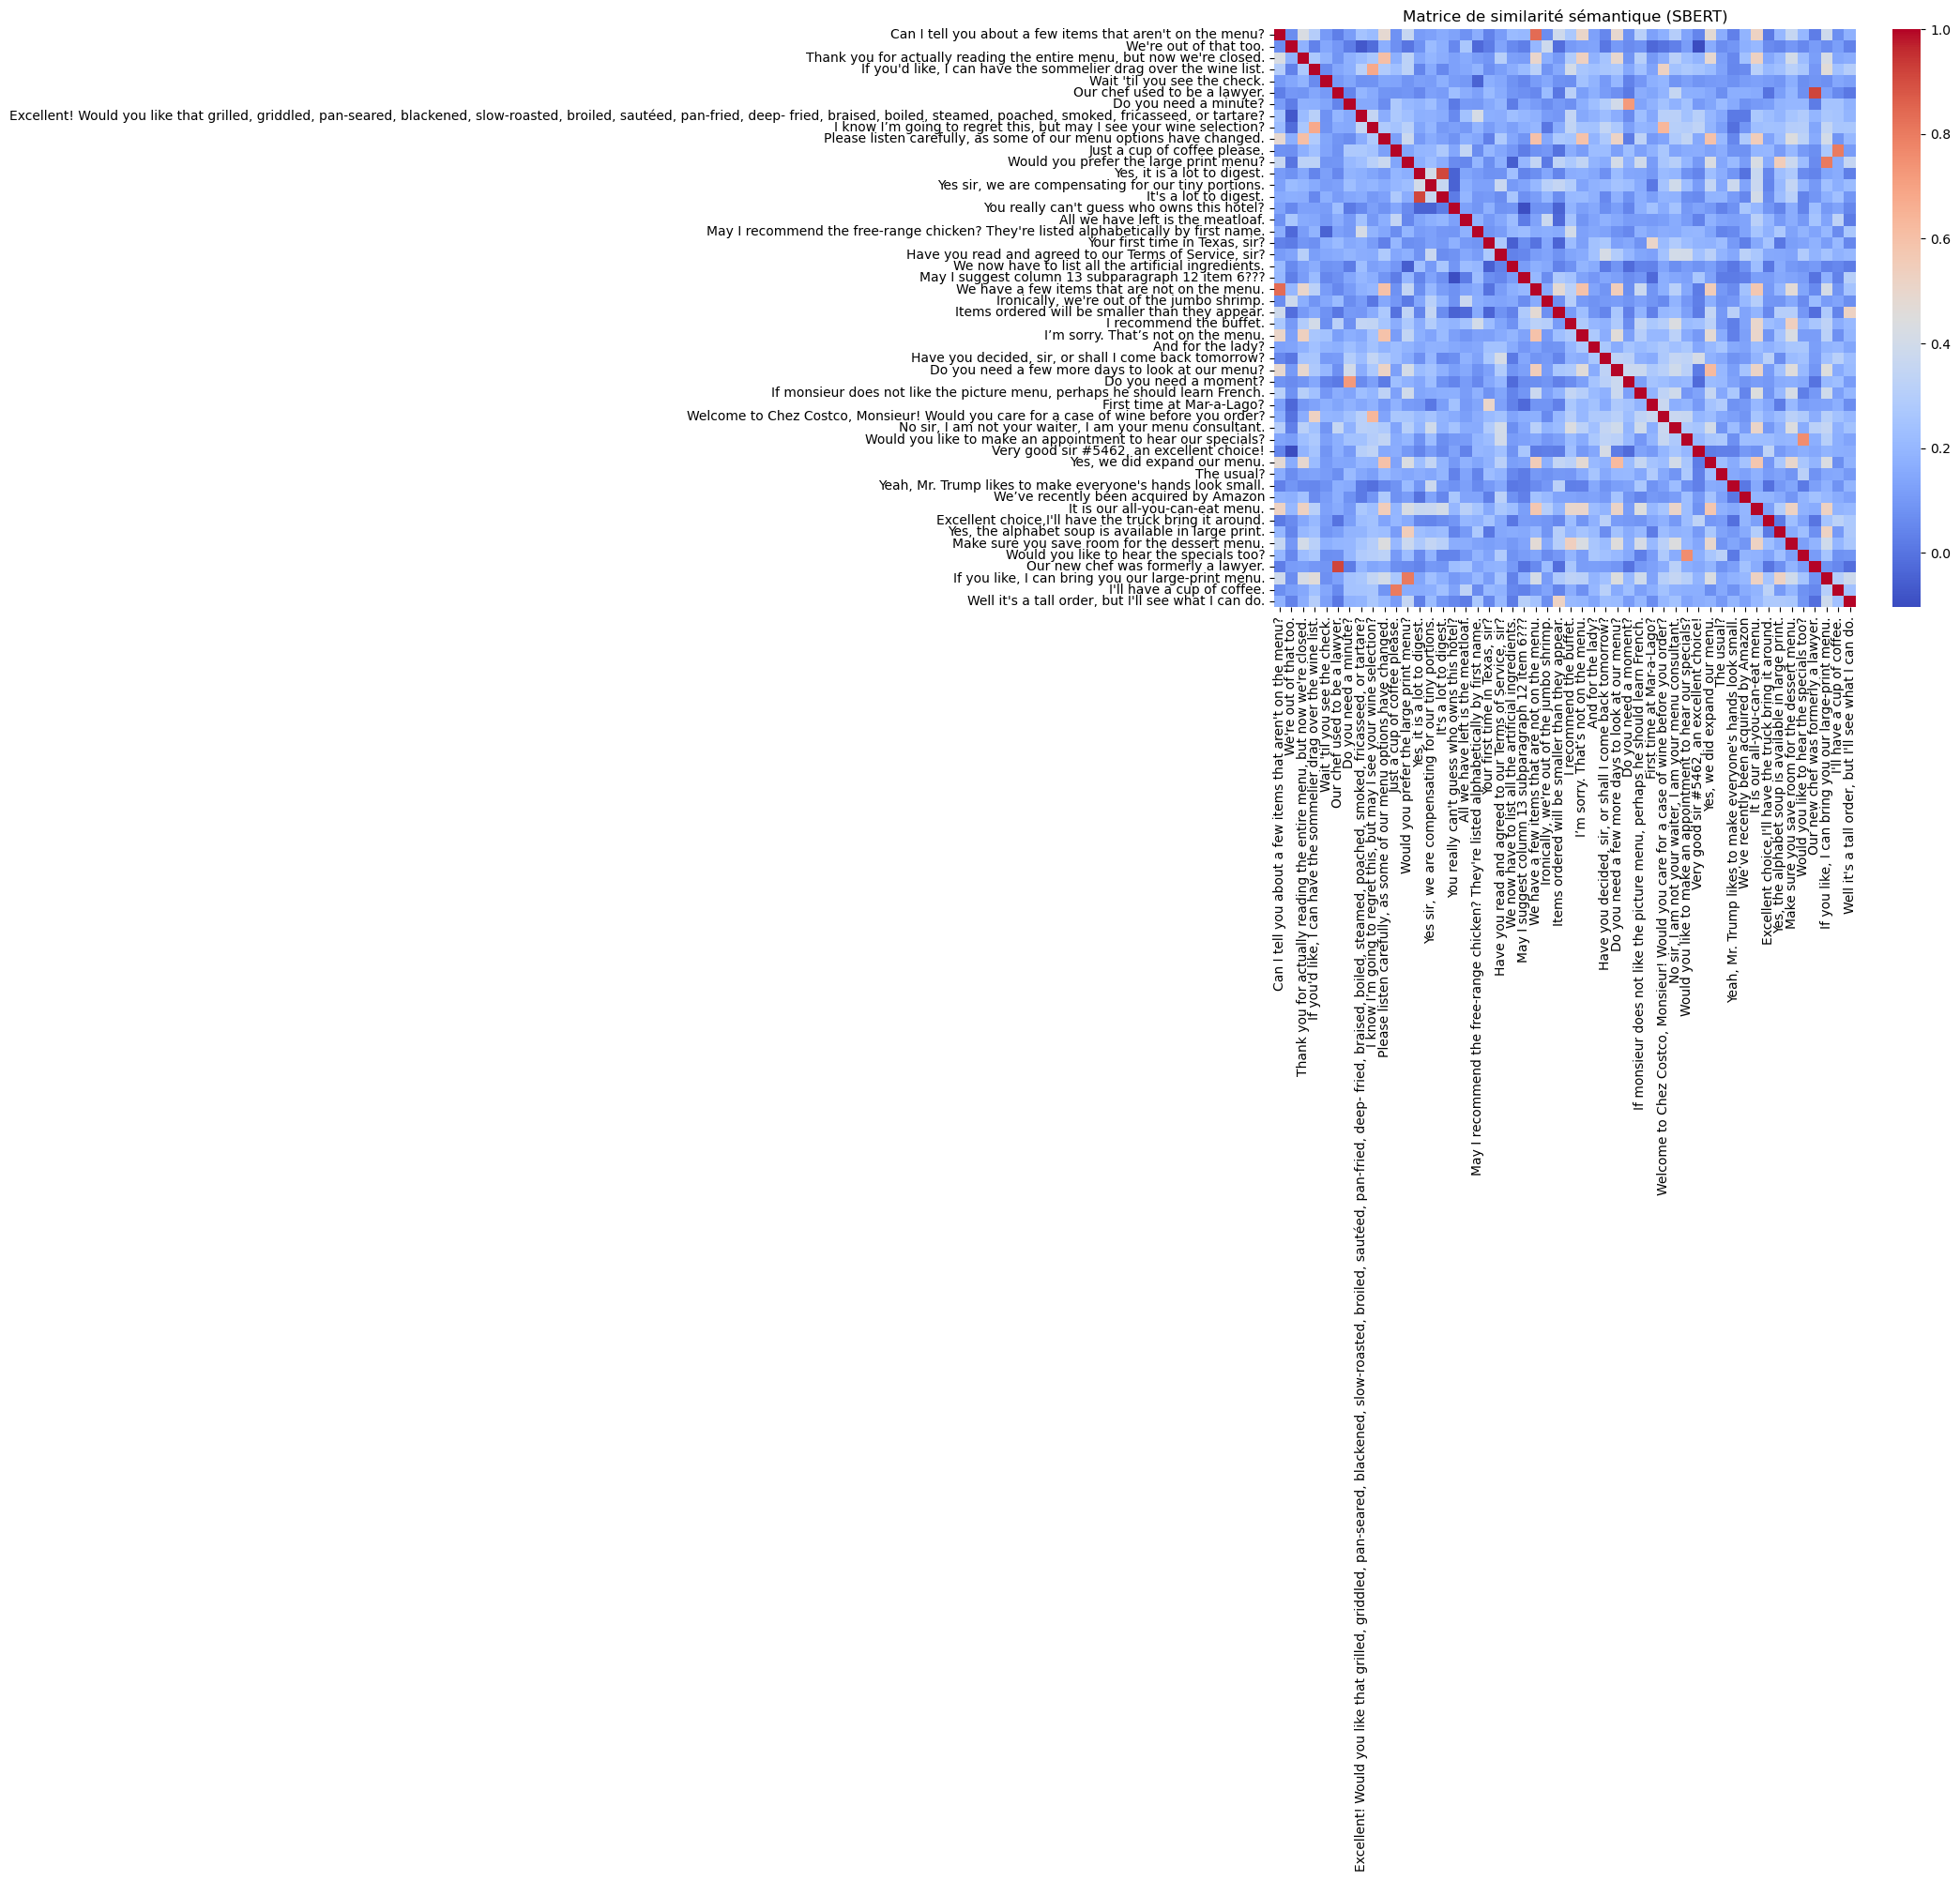

In [10]:
df_sim1 = plot_similarity_matrix(dataA[77], text_col='caption', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=1, structural_sim_ratio=0, sample_size=50)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_33264\3945235727.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


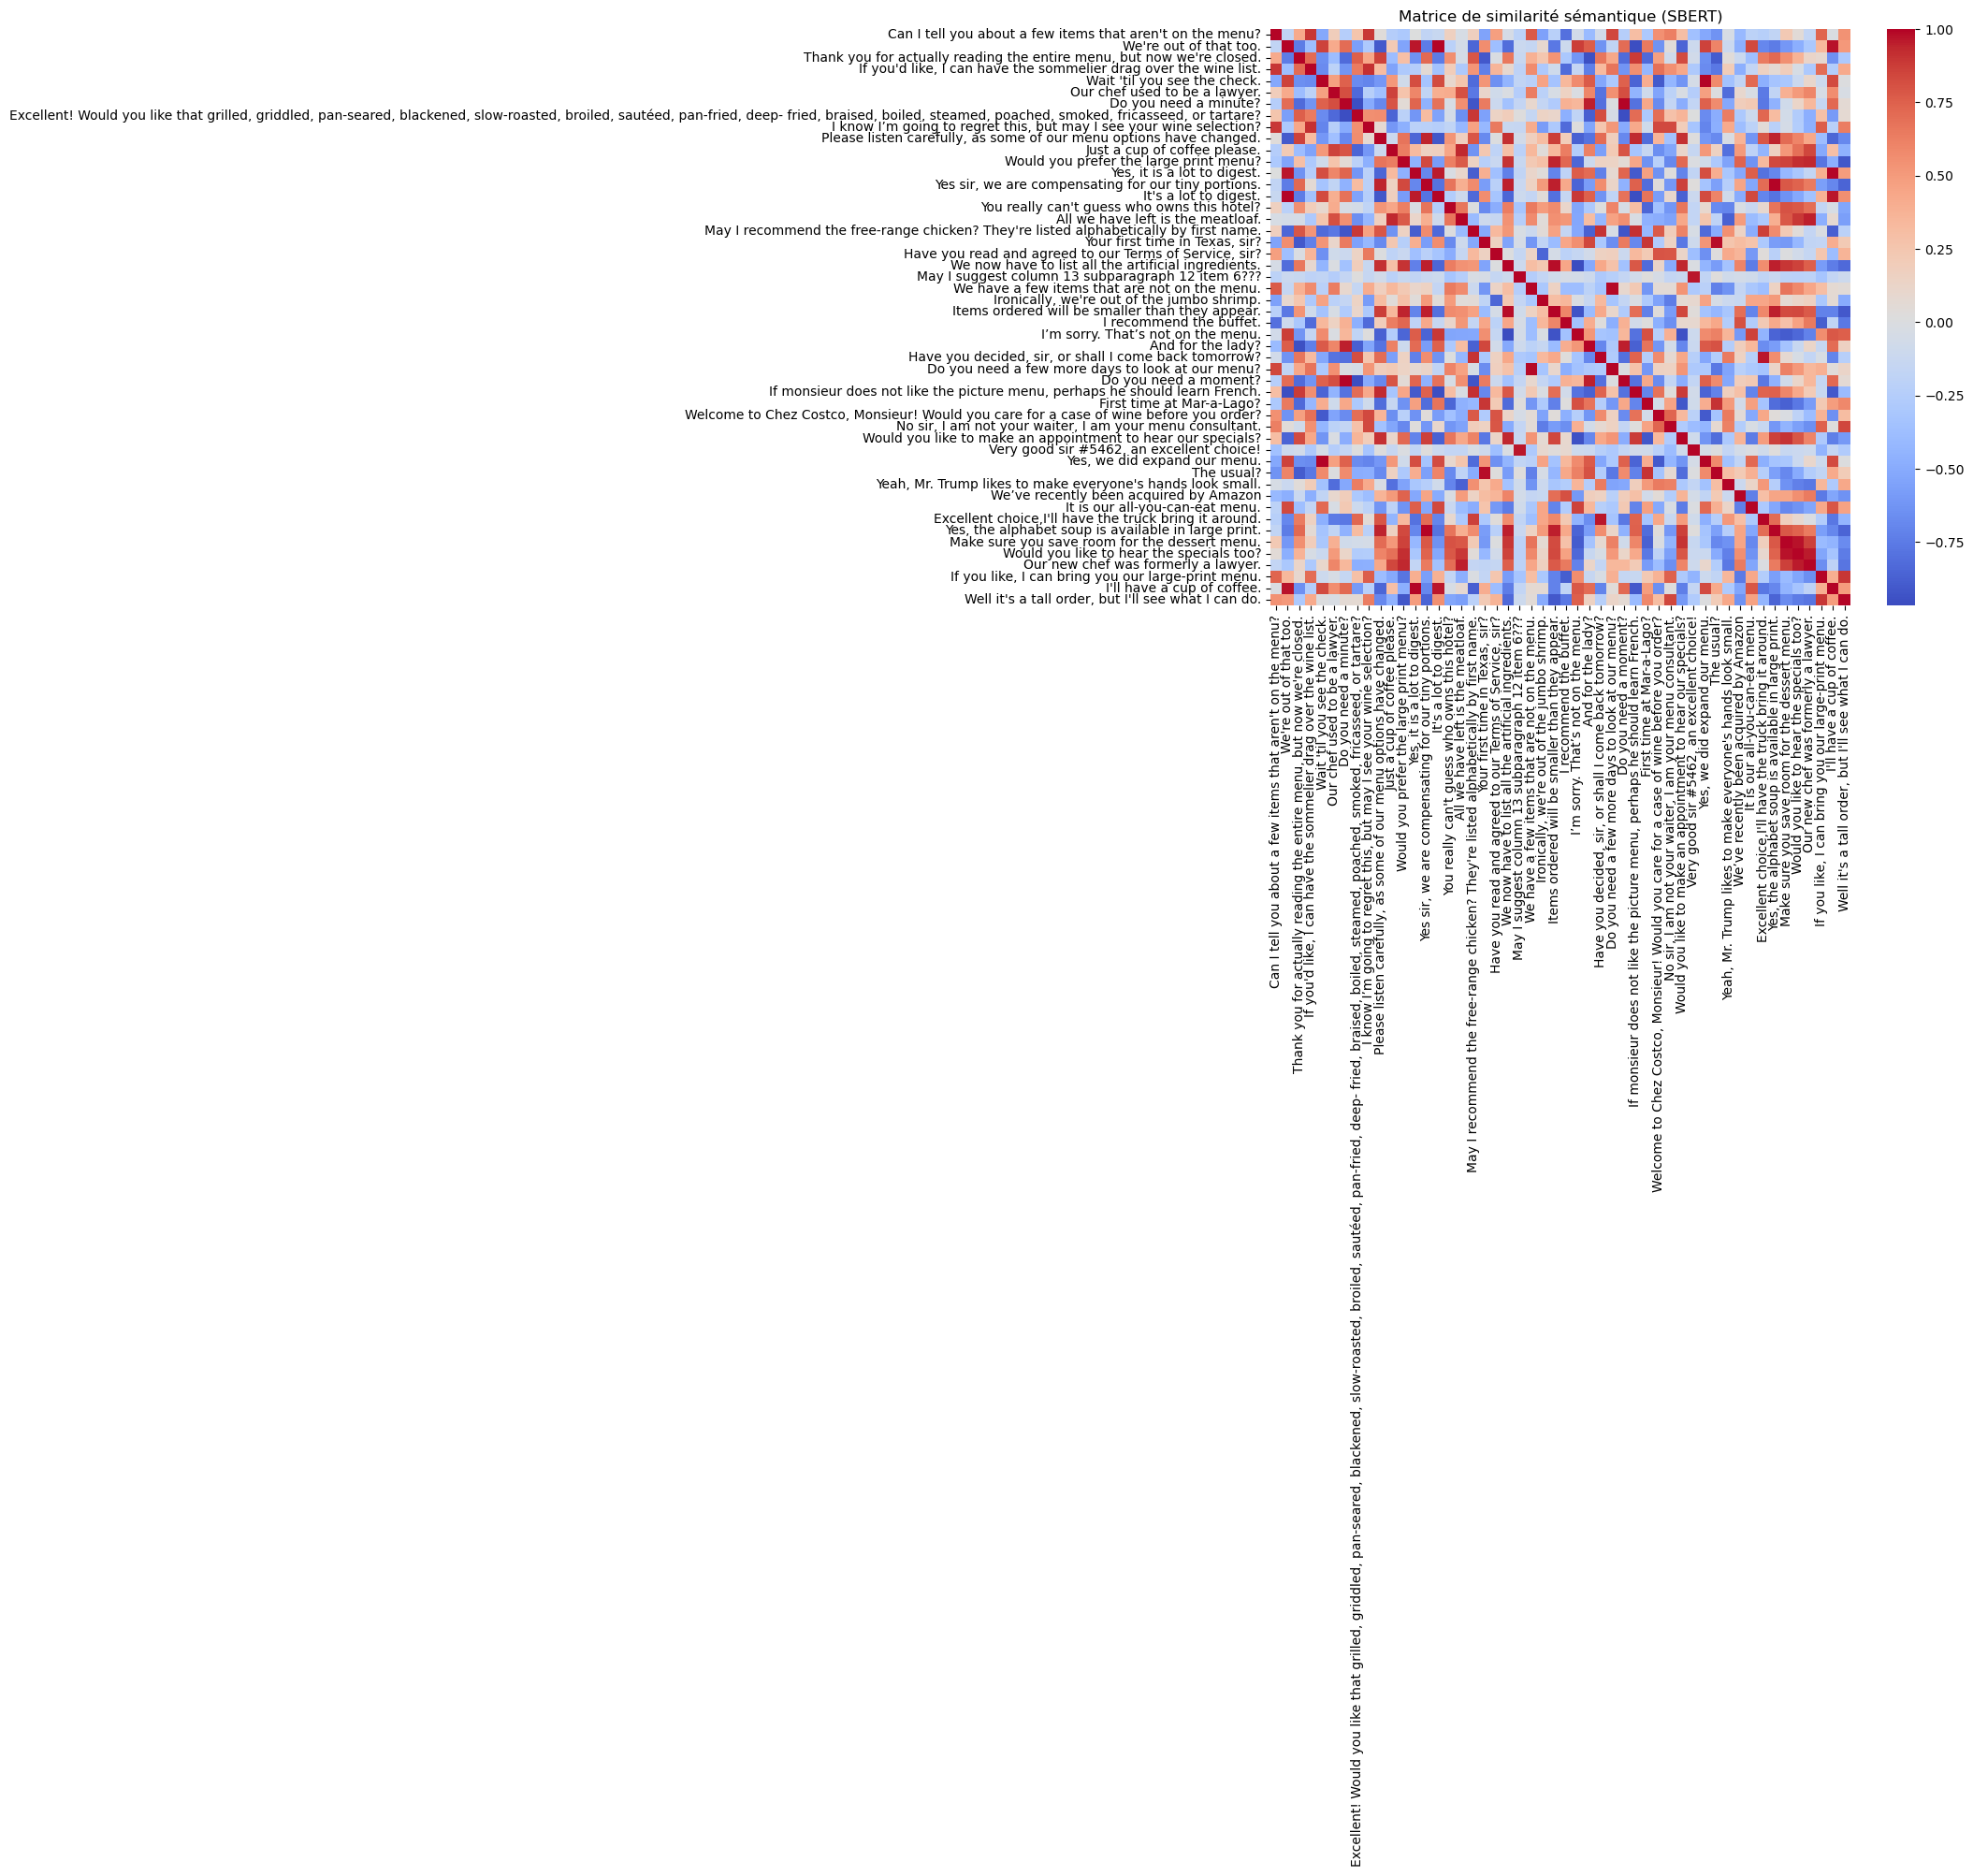

In [11]:
df_sim2 = plot_similarity_matrix(dataA[77], text_col='caption', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0, structural_sim_ratio=1, sample_size=50)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_33264\3945235727.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


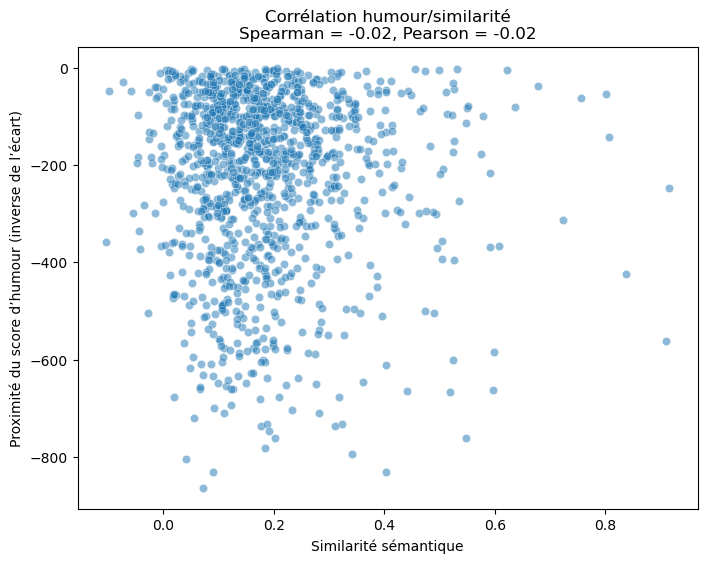

In [12]:
corr_spearman1, corr_spearman1 = analyze_humor_similarity(dataA[77], text_col='caption', humor_col='funny', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=1, structural_sim_ratio=0, sample_size=50)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_33264\3945235727.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  combined_sim_matrix = semantic_sim_ratio * semantic_sim + structural_sim_ratio * structural_sim


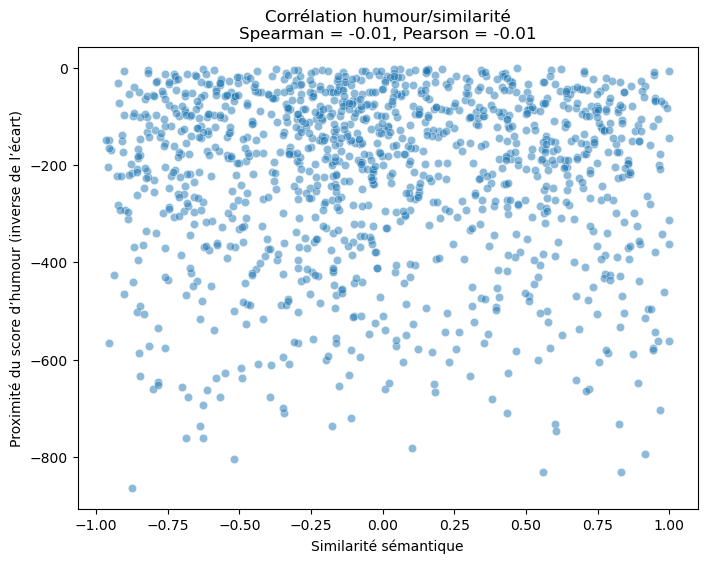

In [13]:
corr_spearman2, corr_spearman2 = analyze_humor_similarity(dataA[77], text_col='caption', humor_col='funny', model_name='all-MiniLM-L6-v2', semantic_sim_ratio=0, structural_sim_ratio=1, sample_size=50)

Plusieurs bandes horizontales --> cela vient du fait que les scores d’humour sont discrets (ex. 0–5), donc certaines valeurs de -humor_diffs sont répétées\

Une forte densité en haut (proximité de 0) --> beaucoup de paires ont des scores d’humour très proches indépendement leur niveau de similarité.

In [14]:
# comme je prend un échantillon aléatoire de caption, qui sont à la base ordonnées par rang de la meilleure caption (la plus drole) à la moins bonne caption, est ce qu'il ne faudrait mieux pas prendre des echantillons ordonnés ?
# Deuxième question, comment est il possible de procéder à cette analyse dans le but de clusteuriser des groupes de captions ? exemple : je veux analyser l'humour des captions au sein de clusters qui évoquent des axes de stratégies de blagues similaires

## Lexical network out of the captions

In [40]:
STORED_CLEAN_DATAPREP_PKL_PATH = STORED_MAIN_DIR_PATH / "cleaned_data_prepared.pkl"

In [41]:
# Chargement du fichier pickle
with open(root / STORED_CLEAN_DATAPREP_PKL_PATH, "rb") as f:
    lemmatized_data = pickle.load(f)

In [23]:
lemmatized_data['dataA'][77]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,cleaned_caption
rank,,,,,,,,
0,Can I tell you about a few items that aren't o...,1.962439,0.015871,2476,820,929,727,tell item menu
1,We're out of that too.,1.960586,0.018005,1979,675,707,597,
2,Thank you for actually reading the entire menu...,1.929282,0.018846,1810,650,638,522,thank actually reading entire menu closed
3,"If you'd like, I can have the sommelier drag o...",1.913781,0.020508,1415,487,563,365,would like sommelier drag wine list
4,Wait 'til you see the check.,1.913360,0.015410,2747,1025,935,787,wait til see check
...,...,...,...,...,...,...,...,...
6085,You're the smallest person we've ever had here!,1.000000,0.016261,62,62,0,0,smallest person ever
6086,Wait till you see the size of our dessert menu!,1.000000,0.016261,62,62,0,0,wait till see size dessert menu
6087,Welcome to Texas.,1.000000,0.005168,194,194,0,0,welcome texas


In [39]:
lemmatized_data['dataA'][77]['cleaned_caption']

rank
0                                  tell item menu
1                                                
2       thank actually reading entire menu closed
3             would like sommelier drag wine list
4                              wait til see check
                          ...                    
6085                         smallest person ever
6086              wait till see size dessert menu
6087                                welcome texas
6088        wine list wheeled think find adequate
6089               wait til see chef amuse fouche
Name: cleaned_caption, Length: 6090, dtype: object

In [35]:
def build_lexical_network(caption_list):
    """
    Build a lexical network based on co-occurrence of words in captions.
    """
    # Tokenize and preprocess
    tokenized_captions = [c for c in caption_list]

    # Build co-occurrence matrix
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
    X = vectorizer.fit_transform(tokenized_captions)
    vocab = vectorizer.get_feature_names_out()

    cooccurrence = (X.T @ X).toarray()  # co-occurrence count matrix
    np.fill_diagonal(cooccurrence, 0)  # remove self-loops

    # Build graph
    G = nx.Graph()
    for i, word1 in enumerate(vocab):
        for j, word2 in enumerate(vocab):
            if cooccurrence[i, j] > 0:
                G.add_edge(word1, word2, weight=cooccurrence[i, j])
    
    return G

def plot_lexical_network(G, top_n=30):
    """
    Plot the lexical network, optionally focusing on top_n nodes by degree.
    """
    # Select top_n nodes by degree
    degrees = dict(G.degree(weight='weight'))
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    H = G.subgraph(top_nodes)

    pos = nx.spring_layout(H, seed=42)
    sizes = [degrees[n]*50 for n in H.nodes()]  # node size proportional to degree
    weights = [H[u][v]['weight'] for u,v in H.edges()]  # edge width

    plt.figure(figsize=(12, 8))
    nx.draw(H, pos, with_labels=True, node_size=sizes, width=weights, edge_color='grey', node_color='skyblue')
    plt.title("Lexical Network of Captions (Top Words)")
    plt.show()

In [ ]:
#pour itérer sur tous les contests :

"""for contest_name, df_contest in df.groupby("contest"):
    print(f"Contest: {contest_name}")
    captions = df_contest['caption'].tolist()
    G = build_lexical_network(captions)
    plot_lexical_network(G, top_n=30)"""

c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


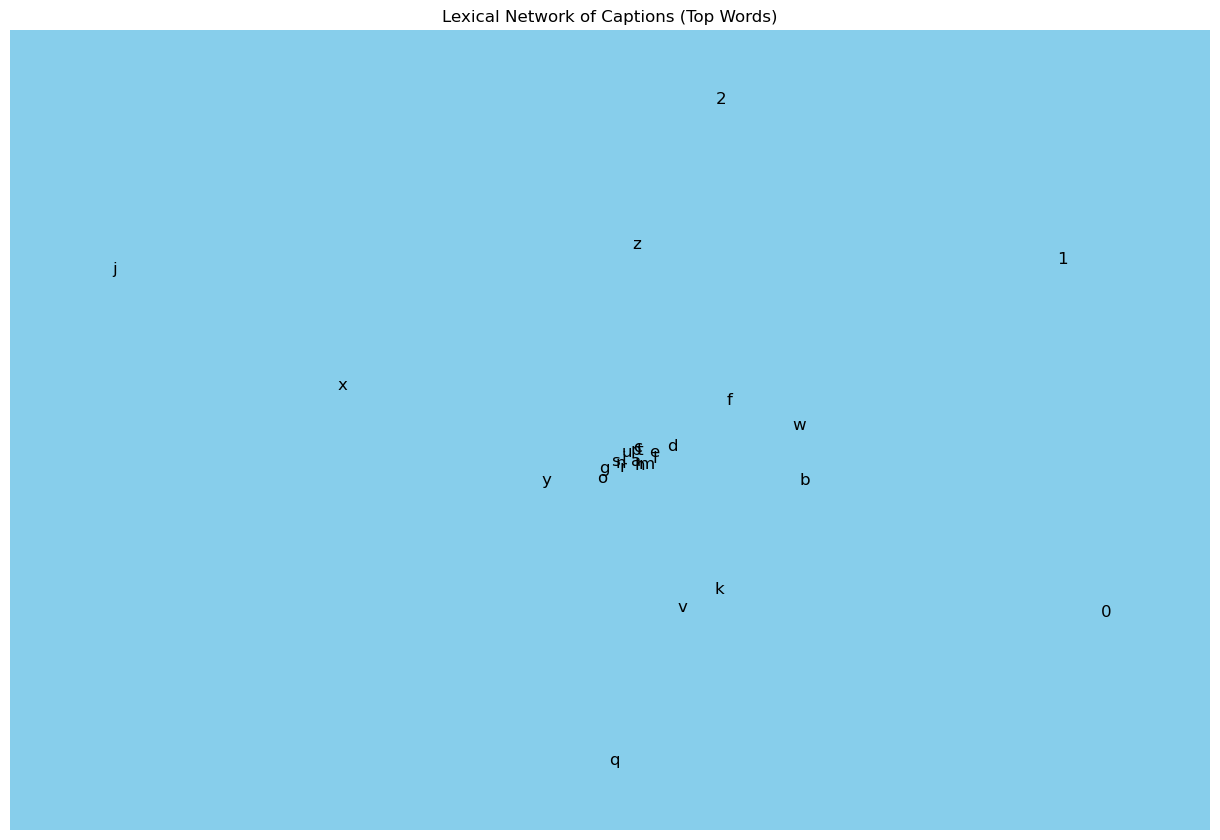

In [ ]:
# pour un seul contest:
captions = lemmatized_data['dataA'][77]['cleaned_caption'].tolist()

G = build_lexical_network(captions)
plot_lexical_network(G, top_n=30)